In [ ]:
### Matching Mentors Mentees
## sentence-transformers/all-MiniLM-L6-v2
## https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
## Main page https://huggingface.co/sentence-transformers
## "This is a sentence-transformers model: It maps sentences & paragraphs
## to a 384 dimensional dense vector space and can be used for tasks
## like clustering or semantic search."

## I've generated 2 example CSV files with 124 mentors and 458 mentees.
## Mentors and mentees have a "name_id" , "keywords" and "description"
## I've used a sentence transformer to extract features and do the pairing.
## In this example, the all-MiniLM-L6-v2 transformers looks for semantic similarities
## and evaluates "keywords" and "description"

## The "framework"
## Github https://github.com/varlottaang/matching
## CSV Mentors https://github.com/varlottaang/matching/blob/main/mentors.csv
## CSV Mentees https://github.com/varlottaang/matching/blob/main/mentees.csv

## "climate modeling", "climate system", "ocean reanalysis", "atmosphere reanalysis", "paleoclimate",
## "extremes and vulnerability", "adaptation and impact", "IPCC", "climate response", "climate future",
## "climate data", "heatwaves", "wildfires", "precipitations", "ENSO", "land use",
## "ocean acidification", "sea level rise"

In [ ]:
# install sentence transformer 🚚
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=4adc61f220f267d9e8cdc4a5eaed60fec0c17886ca2e08a44c67db7b45fe3bdd
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
# import packages 📦
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util

In [ ]:
# Load CSV files
mentors_df = pd.read_csv('mentors.csv')
mentees_df = pd.read_csv('mentees.csv')

# Extract names, keywords, and descriptions
mentors = mentors_df[['name_id', 'keywords', 'description']]
mentees = mentees_df[['name_id', 'keywords', 'description']]

In [ ]:
## Load Model sentence-transformers/all-MiniLM-L6-v2🤗

In [ ]:
# Load pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to compute embeddings for both keywords and description
def compute_embeddings(keywords, descriptions):
    keyword_embeddings = model.encode(keywords, convert_to_tensor=True)
    description_embeddings = model.encode(descriptions, convert_to_tensor=True)
    return keyword_embeddings + description_embeddings

# Compute embeddings for mentors and mentees
mentor_embeddings = compute_embeddings(mentors['keywords'], mentors['description'])
mentee_embeddings = compute_embeddings(mentees['keywords'], mentees['description'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
## Matching 🧩

In [ ]:
# Dictionary to keep track of mentor matches
mentor_match_count = {mentor: 0 for mentor in mentors['name_id']}

# Set of all mentee names, to look for unmatch later
unmatched_mentees = set(mentees['name_id'])

# Set the desired number of matches for each mentor
# Divide the total number of mentees by the number of mentors
# The result // is an integer
matches_per_mentor = len(mentees) // len(mentors)

# Match mentors and mentees
matches_with_scores = []
for mentee_idx, mentee_embedding in enumerate(mentee_embeddings):
    # Compute cosine similarity
    similarities = util.cos_sim(mentee_embedding, mentor_embeddings)[0]

    # Iterate over similarities to find an available mentor
    for best_match_idx in similarities.argsort(descending=True):
        best_match_idx = best_match_idx.item()  # Convert to integer
        mentor_name = mentors['name_id'].iloc[best_match_idx]

        # Check if mentor has not exceeded the desired match limit
        if mentor_match_count[mentor_name] < matches_per_mentor:
            mentee_name = mentees['name_id'].iloc[mentee_idx]
            similarity_score = similarities[best_match_idx].item()

            matches_with_scores.append((mentee_name, mentor_name, similarity_score))
            mentor_match_count[mentor_name] += 1
            # Remove matched mentee from the set
            unmatched_mentees.discard(mentee_name)
            break


In [ ]:
# Print the matches Mentees-Mentors with similarity scores
for mentee, mentor, score in matches_with_scores:
    print(f"Mentee: {mentee} is best matched with Mentor: {mentor} (Similarity Score: {score:.4f})")

Mentee: Mentee_1 is best matched with Mentor: Mentor_91 (Similarity Score: 0.9457)
Mentee: Mentee_2 is best matched with Mentor: Mentor_96 (Similarity Score: 0.9388)
Mentee: Mentee_3 is best matched with Mentor: Mentor_54 (Similarity Score: 0.9395)
Mentee: Mentee_4 is best matched with Mentor: Mentor_98 (Similarity Score: 0.9545)
Mentee: Mentee_5 is best matched with Mentor: Mentor_110 (Similarity Score: 0.9276)
Mentee: Mentee_6 is best matched with Mentor: Mentor_30 (Similarity Score: 0.9483)
Mentee: Mentee_7 is best matched with Mentor: Mentor_11 (Similarity Score: 0.9330)
Mentee: Mentee_8 is best matched with Mentor: Mentor_104 (Similarity Score: 0.9407)
Mentee: Mentee_9 is best matched with Mentor: Mentor_93 (Similarity Score: 0.9401)
Mentee: Mentee_10 is best matched with Mentor: Mentor_52 (Similarity Score: 0.9308)
Mentee: Mentee_11 is best matched with Mentor: Mentor_26 (Similarity Score: 0.9748)
Mentee: Mentee_12 is best matched with Mentor: Mentor_96 (Similarity Score: 0.9453)

In [ ]:
## Save Mentors-Mentees Matching as a CSV 👩‍🏫🧑🏿‍🏫👨🏻‍🏫👩🏽‍🎓👨‍🎓🧑🏻‍🎓

In [ ]:
# Convert the list of matches to a DataFrame
matches_df = pd.DataFrame(matches_with_scores, columns=['Mentee', 'Mentor', 'Similarity Score'])

# Save the DataFrame to a CSV file
matches_df.to_csv('mentee_mentor_matches.csv', index=False)

In [ ]:
## Spot lonely Mentors, print and save a CSV 💫

In [ ]:
# Identify and print unpaired mentors
unpaired_mentors = [mentor for mentor, count in mentor_match_count.items() if count == 0]
print("Unpaired Mentors:")
for mentor in unpaired_mentors:
    print(mentor)

# Convert the list of unpaired mentors to a DataFrame
unpaired_mentors_df = pd.DataFrame(unpaired_mentors, columns=['Unpaired Mentor'])

# Save the DataFrame of unpaired mentors to a CSV file
unpaired_mentors_df.to_csv('unpaired_mentors.csv', index=False)

Unpaired Mentors:


In [ ]:
## Unmatched Mentees (Home Alone) 🏡
## Print and save a CSV

In [ ]:
# Print and save the unmatched mentees
print("Unmatched Mentees:")
for mentee in unmatched_mentees:
    print(mentee)

# Convert the set of unmatched mentees to a DataFrame
unmatched_mentees_df = pd.DataFrame(list(unmatched_mentees), columns=['Unmatched Mentee'])

# Save the DataFrame of unmatched mentees to a CSV file
unmatched_mentees_df.to_csv('unmatched_mentees.csv', index=False)

Unmatched Mentees:
Mentee_433
Mentee_387
Mentee_432
Mentee_388
Mentee_435
Mentee_384
Mentee_449
Mentee_431
Mentee_429
Mentee_397
Mentee_424
Mentee_426
Mentee_394
Mentee_385
Mentee_377
Mentee_455
Mentee_372
Mentee_430
Mentee_389
Mentee_417
Mentee_379
Mentee_390
Mentee_415
Mentee_457
Mentee_370
Mentee_437
Mentee_421
Mentee_375
Mentee_402
Mentee_446
Mentee_452
Mentee_422
Mentee_428
Mentee_414
Mentee_438
Mentee_378
Mentee_439
Mentee_395
Mentee_386
Mentee_411
Mentee_392
Mentee_419
Mentee_374
Mentee_393
Mentee_391
Mentee_410
Mentee_443
Mentee_380
Mentee_400
Mentee_408
Mentee_458
Mentee_444
Mentee_381
Mentee_399
Mentee_447
Mentee_420
Mentee_448
Mentee_405
Mentee_423
Mentee_376
Mentee_454
Mentee_440
Mentee_441
Mentee_425
Mentee_398
Mentee_406
Mentee_450
Mentee_418
Mentee_434
Mentee_412
Mentee_453
Mentee_442
Mentee_382
Mentee_456
Mentee_404
Mentee_427
Mentee_445
Mentee_409
Mentee_407
Mentee_401
Mentee_413
Mentee_373
Mentee_383
Mentee_371
Mentee_403
Mentee_416
Mentee_396
Mentee_451
Mentee_436


In [ ]:
# Reset match count for mentors
mentor_match_count = {mentor: 0 for mentor in mentors['name_id']}

# Match mentors and remaining unmatched mentees
remaining_matches_with_scores = []
for mentee_idx, mentee_embedding in enumerate(mentee_embeddings):
    # If the mentee is already matched, skip to the next one
    if mentees['name_id'].iloc[mentee_idx] not in unmatched_mentees:
        continue

    # Compute cosine similarity
    similarities = util.cos_sim(mentee_embedding, mentor_embeddings)[0]

    # Iterate over similarities to find an available mentor
    for best_match_idx in similarities.argsort(descending=True):
        best_match_idx = best_match_idx.item()  # Convert to integer
        mentor_name = mentors['name_id'].iloc[best_match_idx]

        # Check if mentor has not exceeded the desired match limit
        if mentor_match_count[mentor_name] < matches_per_mentor:
            mentee_name = mentees['name_id'].iloc[mentee_idx]
            similarity_score = similarities[best_match_idx].item()

            remaining_matches_with_scores.append((mentee_name, mentor_name, similarity_score))
            mentor_match_count[mentor_name] += 1
            # Remove matched mentee from the set
            unmatched_mentees.discard(mentee_name)
            break

In [ ]:
# Print the remaining matches Mentees-Mentors with similarity scores
for mentee, mentor, score in remaining_matches_with_scores:
    print(f"Remaining Match - Mentee: {mentee} is matched with Mentor: {mentor} (Similarity Score: {score:.4f})")

Remaining Match - Mentee: Mentee_370 is matched with Mentor: Mentor_77 (Similarity Score: 0.9509)
Remaining Match - Mentee: Mentee_371 is matched with Mentor: Mentor_84 (Similarity Score: 0.9496)
Remaining Match - Mentee: Mentee_372 is matched with Mentor: Mentor_49 (Similarity Score: 0.9263)
Remaining Match - Mentee: Mentee_373 is matched with Mentor: Mentor_52 (Similarity Score: 0.9512)
Remaining Match - Mentee: Mentee_374 is matched with Mentor: Mentor_42 (Similarity Score: 0.9697)
Remaining Match - Mentee: Mentee_375 is matched with Mentor: Mentor_103 (Similarity Score: 0.9592)
Remaining Match - Mentee: Mentee_376 is matched with Mentor: Mentor_113 (Similarity Score: 0.9299)
Remaining Match - Mentee: Mentee_377 is matched with Mentor: Mentor_33 (Similarity Score: 0.9882)
Remaining Match - Mentee: Mentee_378 is matched with Mentor: Mentor_61 (Similarity Score: 0.9517)
Remaining Match - Mentee: Mentee_379 is matched with Mentor: Mentor_81 (Similarity Score: 0.9254)
Remaining Match - 

In [ ]:
# Convert the list of matches to a DataFrame
matches_df = pd.DataFrame(remaining_matches_with_scores, columns=['Mentee', 'Mentor', 'Similarity Score'])

# Save the DataFrame to a CSV file
matches_df.to_csv('remaining_matches_with_scores.csv', index=False)

In [ ]:
## Data Visualization

In [ ]:
# Visualize Number of mentees per mentor
# This is a visualization just for matches_with_scores, without the unmatched mentees

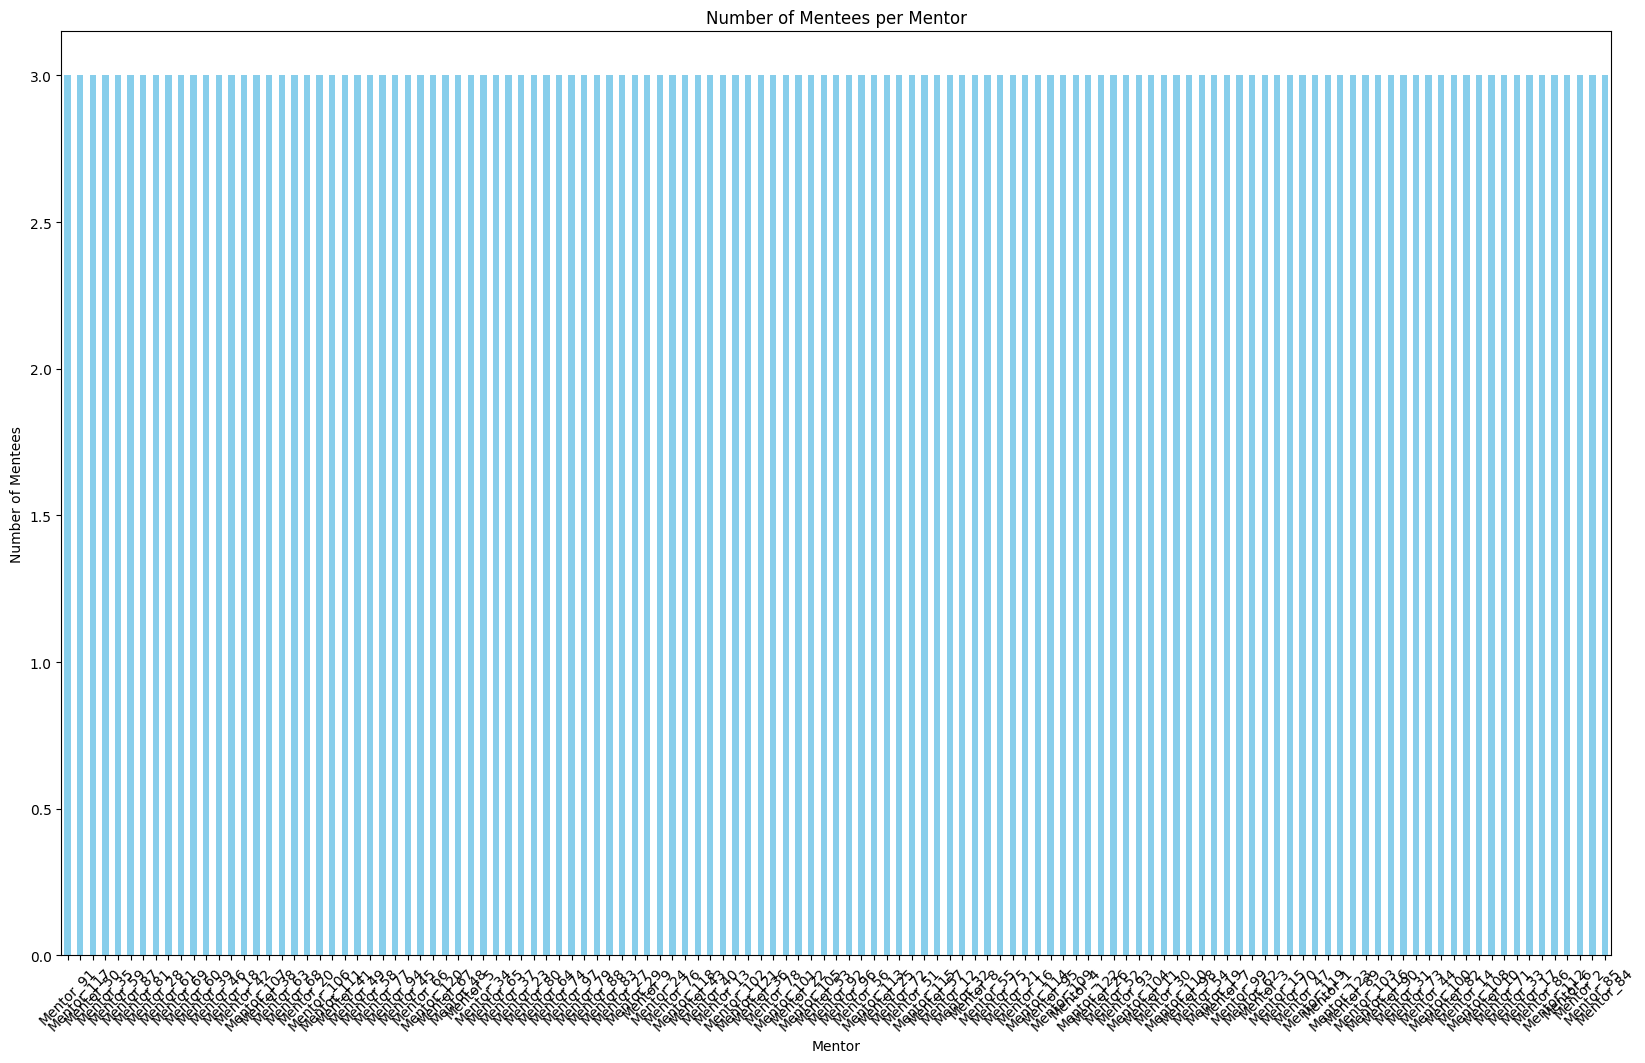

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the list of matches to a DataFrame
matches_df = pd.DataFrame(matches_with_scores, columns=['Mentee', 'Mentor', 'Similarity Score'])
# Count the number of mentees for each mentor
mentee_count_per_mentor = matches_df['Mentor'].value_counts()

# Plot the distribution
mentee_count_per_mentor.plot(kind='bar', figsize=(20, 12), color='skyblue')

plt.title('Number of Mentees per Mentor')
plt.xlabel('Mentor')
plt.ylabel('Number of Mentees')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# WordCloud from CSV files ☁️☁️☁️

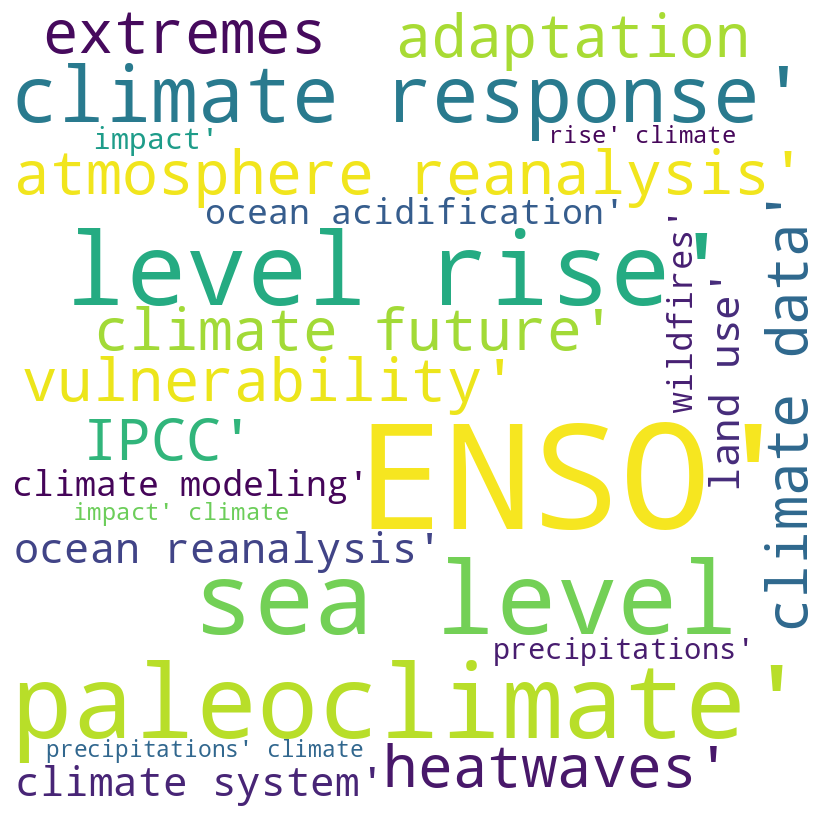

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load CSV files
mentors_df = pd.read_csv('mentors.csv')
mentees_df = pd.read_csv('mentees.csv')

# Combine the keywords from both mentors and mentees
all_keywords = pd.concat([mentors_df['keywords'], mentees_df['keywords']])

# Join all keywords into a single string
text = ' '.join(all_keywords)

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)

# Plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
